In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import starry
import warnings
from scipy.special import legendre
from scipy.integrate import quad


warnings.filterwarnings("ignore")
starry.config.lazy = False
starry.config.quiet = True

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
def phi(y, r=np.inf):
    return np.arcsin(y) + 2 * (1 - np.sqrt(1 - y ** 2)) / (y * r)

def transform(x, y, rs=np.inf):
    # Radial coordinate on disk
    rho = np.sqrt(x ** 2 + y ** 2)
    
    # Angular coordinate on disk (conserved)
    t = np.arctan2(y, x)

    # z coordinate on sphere
    z_ = np.cos(phi(rho, rs))

    # Compute x and y from conserved angle
    x_ = np.sign(x) * np.sqrt((1 - z_ ** 2) / (1 + np.tan(t) ** 2))
    y_ = np.sign(y) * np.sqrt(1 - x_ ** 2 - z_ ** 2)

    # Conver to lat-lon
    lat = np.arcsin(y_)
    lon = np.arctan2(x_, z_)
    return lat * 180 / np.pi, lon * 180 / np.pi

def show(map, nx=300, ax=None, rs=np.inf):
    x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    lat, lon = transform(x, y, rs=rs)
    I = map.intensity(lat=lat , lon=lon).reshape(nx, nx)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
        ax.set_aspect(1)
        ax.axis("off")
    ax.imshow(I, origin="lower")
    

def show_ylms(lmax=5, **kwargs):
    # Set up the plot
    fig, ax = plt.subplots(lmax + 1, 2 * lmax + 1, figsize=(9, 6))
    fig.subplots_adjust(hspace=0)
    for axis in ax.flatten():
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["bottom"].set_visible(False)
        axis.spines["left"].set_visible(False)
    for l in range(lmax + 1):
        ax[l, lmax - l].set_ylabel(
            r"$l = %d$" % l,
            rotation="horizontal",
            labelpad=15,
            y=0.35,
            fontsize=11,
            alpha=0.5,
        )
    for j, m in enumerate(range(-lmax, lmax + 1)):
        if m < 0:
            ax[-1, j].set_xlabel(
                r"$m {=} $-$%d$" % -m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.3,
                alpha=0.5,
            )
        else:
            ax[-1, j].set_xlabel(
                r"$m = %d$" % m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.35,
                alpha=0.5,
            )

    # Loop over the orders and degrees
    map = starry.Map(lmax)
    for i, l in enumerate(range(lmax + 1)):
        for j, m in enumerate(range(-l, l + 1)):

            # Offset the index for centered plotting
            j += lmax - l

            # Compute the spherical harmonic
            map.reset()
            if l > 0:
                map[l, m] = 1.0
            show(map, ax=ax[i, j], **kwargs)
            ax[i, j].axis("on")
            ax[i, j].set_rasterization_zorder(1)

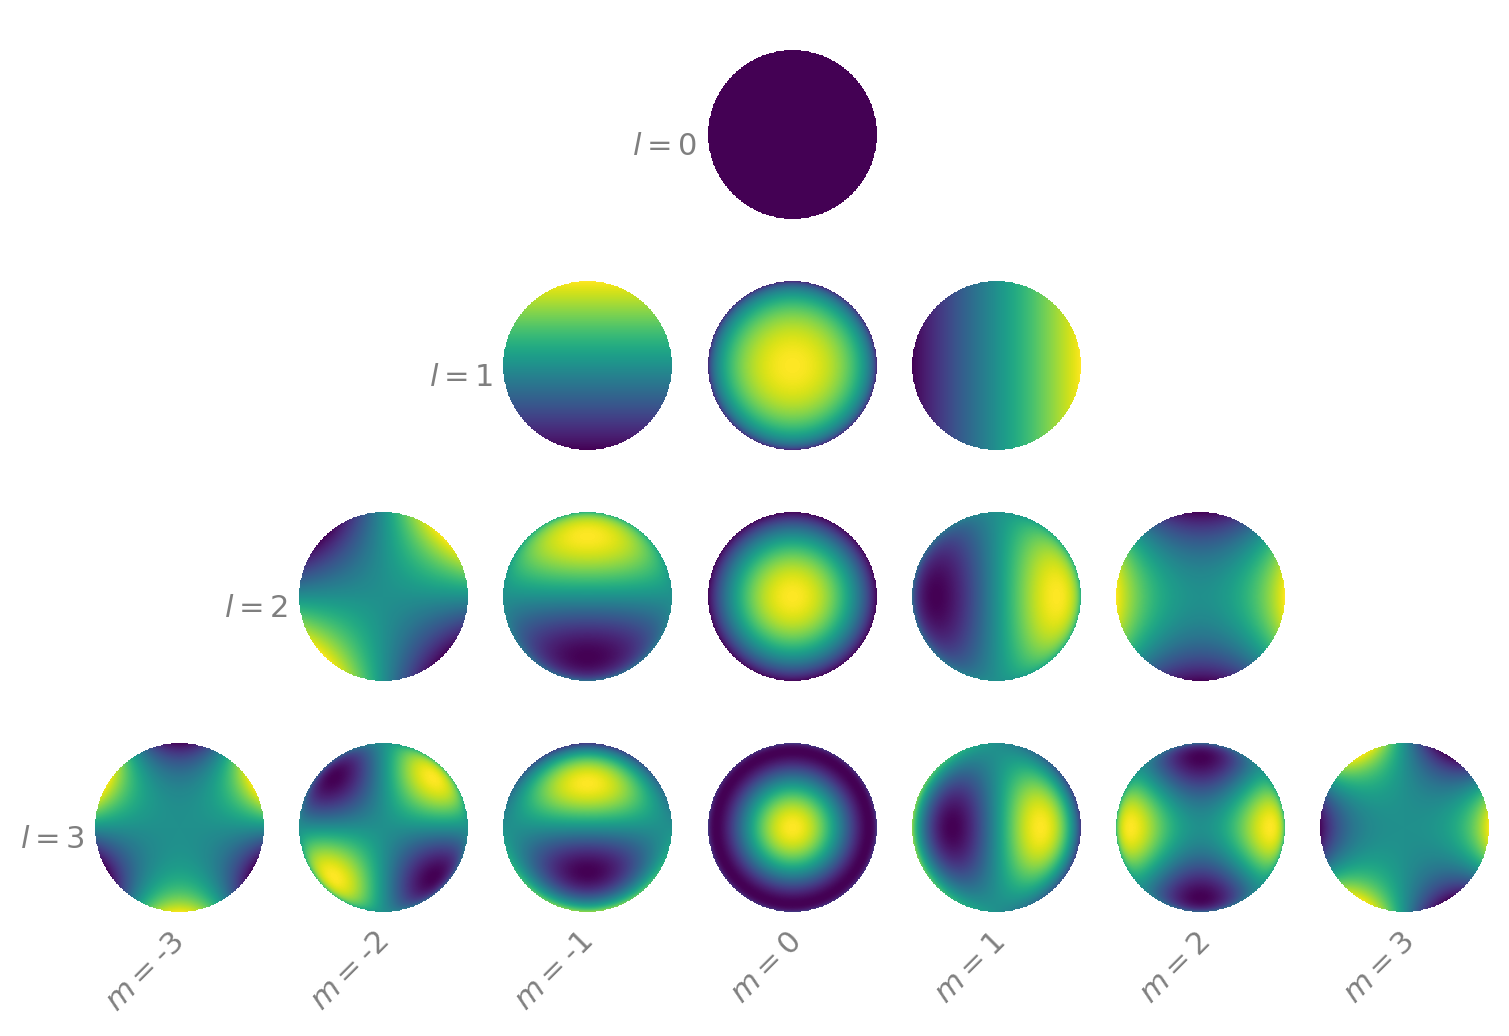

In [5]:
show_ylms(lmax=3, rs=np.inf)

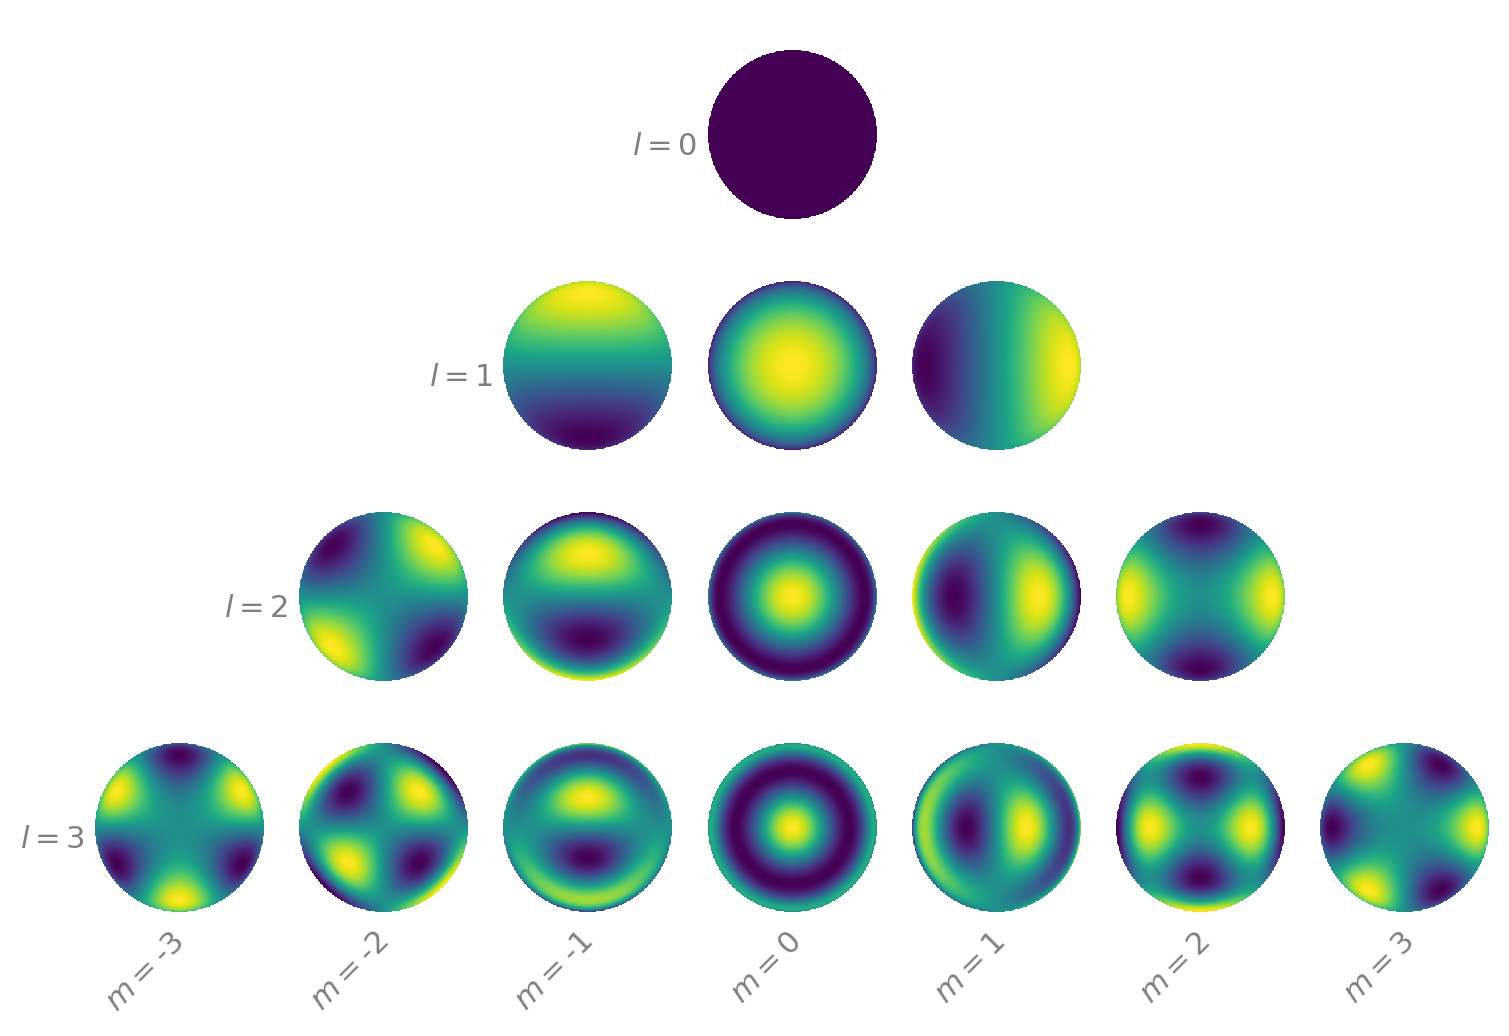

In [6]:
show_ylms(lmax=3, rs=2)

In [7]:
def energy(r, l, theta, rs, vrot):
    """
    the relation between the energy observed at 
    infinite distance and the emitted energy at the surface
    """
    y = r * np.sin(theta)
    e = 1 - y * vrot * np.sin(theta) + (y**2 - 1/2) * vrot**2 * np.sin(theta)**2 - 1/rs * (1 - (y**2 - 1/2) * vrot**2 * np.sin(theta)**2)
    return e


The energy factor we're interested in here is: 
$$e/e_{surf} = 1 - yv_{rot}\sin{\theta_0} + (y^2 - 1/2)v_{rot}^2\sin{\theta_0^2} - \frac{1}{r_s}(1-(y^2 - 1/2)v_{rot}^2\sin{\theta_0}^2)$$

In [11]:
theta = np.linspace(0, 360, 100)

In [55]:
import numpy as np
from scipy import integrate, special

def colat(r, rs):
    return 2 * (1 - np.sqrt(1 - r**2)) / (r * rs)

def spherical_harmonic_intensity(r, l, theta, rs, vrot):
    def integrand(r):
        x = np.sqrt(1 - r**2) * np.cos(colat(r, rs)) - r * np.sin(colat(r, rs))
        return special.legendre(l)(x) * r
    
    result, _ = integrate.quad(integrand, 0, 1)
    Fl = 2 * np.sqrt(2 * l + 1) * result * energy(r, l, theta, rs, vrot)
    return Fl

intensity = spherical_harmonic_intensity(100, 30, theta, 2, 0.3)


In [47]:
def ylms(r, lmax, theta, rs, vrot):
    I = np.zeros(((lmax + 1) ** 2, len(theta)))
    for l in range(lmax + 1):
        n = l ** 2 + l
        I[n] = 2 * np.pi * spherical_harmonic_intensity(r, lmax, theta, rs, vrot)
    return I

In [48]:
def design_matrix(r, lmax, theta, rs, vrot, inc=90):
    map = starry.Map(lmax)
    rT = ylms(r, lmax, theta, rs=rs, vrot=vrot).reshape(1, -1)
    return map.ops.right_project(
        rT,
        np.array(inc * np.pi / 180),
        np.array(0.0),
        np.atleast_1d(theta) * np.pi / 180,
    )

In [49]:
def flux(y, r, lmax, theta, rs, vrot, inc):
    A = design_matrix(r, lmax, theta, rs, vrot, inc)
    return A @ y

In [50]:
flux(y=map.y, r=100, lmax=30, theta=theta, rs=2, vrot=0.3, inc=90)

array([-2.16660551, -2.22980736, -2.06819777, -1.85761755, -1.75408546,
       -1.66566354, -1.4074941 , -0.99001276, -0.58478865, -0.25998216,
        0.06237667,  0.38515909,  0.54647372,  0.40592672,  0.00583476,
       -0.50121336, -0.99292875, -1.40143946, -1.68306173, -1.82952775,
       -1.86861199, -1.81322643, -1.64003307, -1.34164003, -0.96796604,
       -0.59502245, -0.27806792, -0.04902349,  0.06673934,  0.0519049 ,
       -0.09100395, -0.33206688, -0.61349234, -0.86993265, -1.06761707,
       -1.21791601, -1.3424353 , -1.4403057 , -1.50583527, -1.56152761,
       -1.64755521, -1.77661332, -1.90779716, -1.96891754, -1.91956831,
       -1.80940371, -1.75401205, -1.81322024, -1.90225571, -1.87248279,
       -1.67966382, -1.41738412, -1.18271791, -0.98717989, -0.83034427,
       -0.77113584, -0.83805382, -0.91227234, -0.80879077, -0.49956433,
       -0.19132013, -0.13783808, -0.39598437, -0.78985491, -1.09202813,
       -1.20632913, -1.18307126, -1.10613552, -1.00347557, -0.85

In [51]:
flux(y=map.y, r=2, lmax=30, theta=theta, rs=2, vrot=0.3, inc=90)

array([3.11560246e-04, 4.25804832e-04, 5.12675030e-04, 5.91068662e-04,
       6.80012750e-04, 7.57259965e-04, 7.90712091e-04, 7.90039618e-04,
       7.97886344e-04, 8.40059303e-04, 9.08174417e-04, 9.84114068e-04,
       1.05708535e-03, 1.11551253e-03, 1.14214006e-03, 1.12699722e-03,
       1.08007183e-03, 1.02850857e-03, 1.00225796e-03, 1.01670387e-03,
       1.06222331e-03, 1.11323851e-03, 1.15250928e-03, 1.18291606e-03,
       1.21180593e-03, 1.23245998e-03, 1.23110377e-03, 1.20675719e-03,
       1.17199208e-03, 1.13604850e-03, 1.09909949e-03, 1.06235870e-03,
       1.02909392e-03, 9.90255450e-04, 9.21745106e-04, 8.07378362e-04,
       6.60891416e-04, 5.17825480e-04, 4.07059437e-04, 3.33288851e-04,
       2.82414484e-04, 2.38153992e-04, 1.96292764e-04, 1.68951390e-04,
       1.75116808e-04, 2.23742406e-04, 3.04797992e-04, 3.94649861e-04,
       4.67221306e-04, 5.05061032e-04, 5.11704186e-04, 5.15769066e-04,
       5.51610579e-04, 6.29700374e-04, 7.32980118e-04, 8.42817025e-04,
      

The intensity of the spherical harmonic $Y_{l,0}$ projected onto the disk is

$$
F_l = 2\sqrt{2l + 1}\int_0^1 P_l\left( \sqrt{1 - r^2} \cos \theta(r) - r \sin \theta(r) \right) r dr
$$

where

$$
\theta(r) = 2 \frac{1 - \sqrt{1 - r^2}}{r r_s}
$$

In [49]:
theta = np.linspace(0, 360, 100)

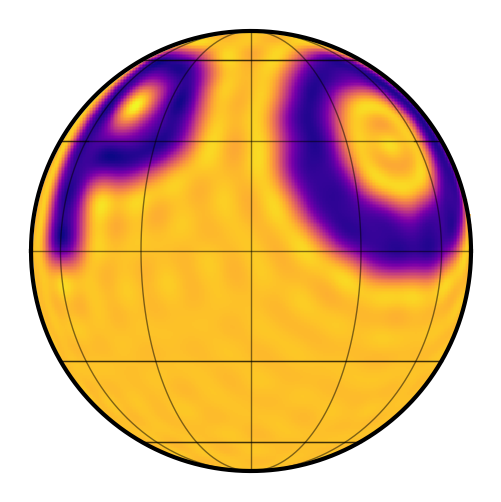

In [99]:
map = starry.Map(30)
map.load("spot")
map.amp = 1
map.show()

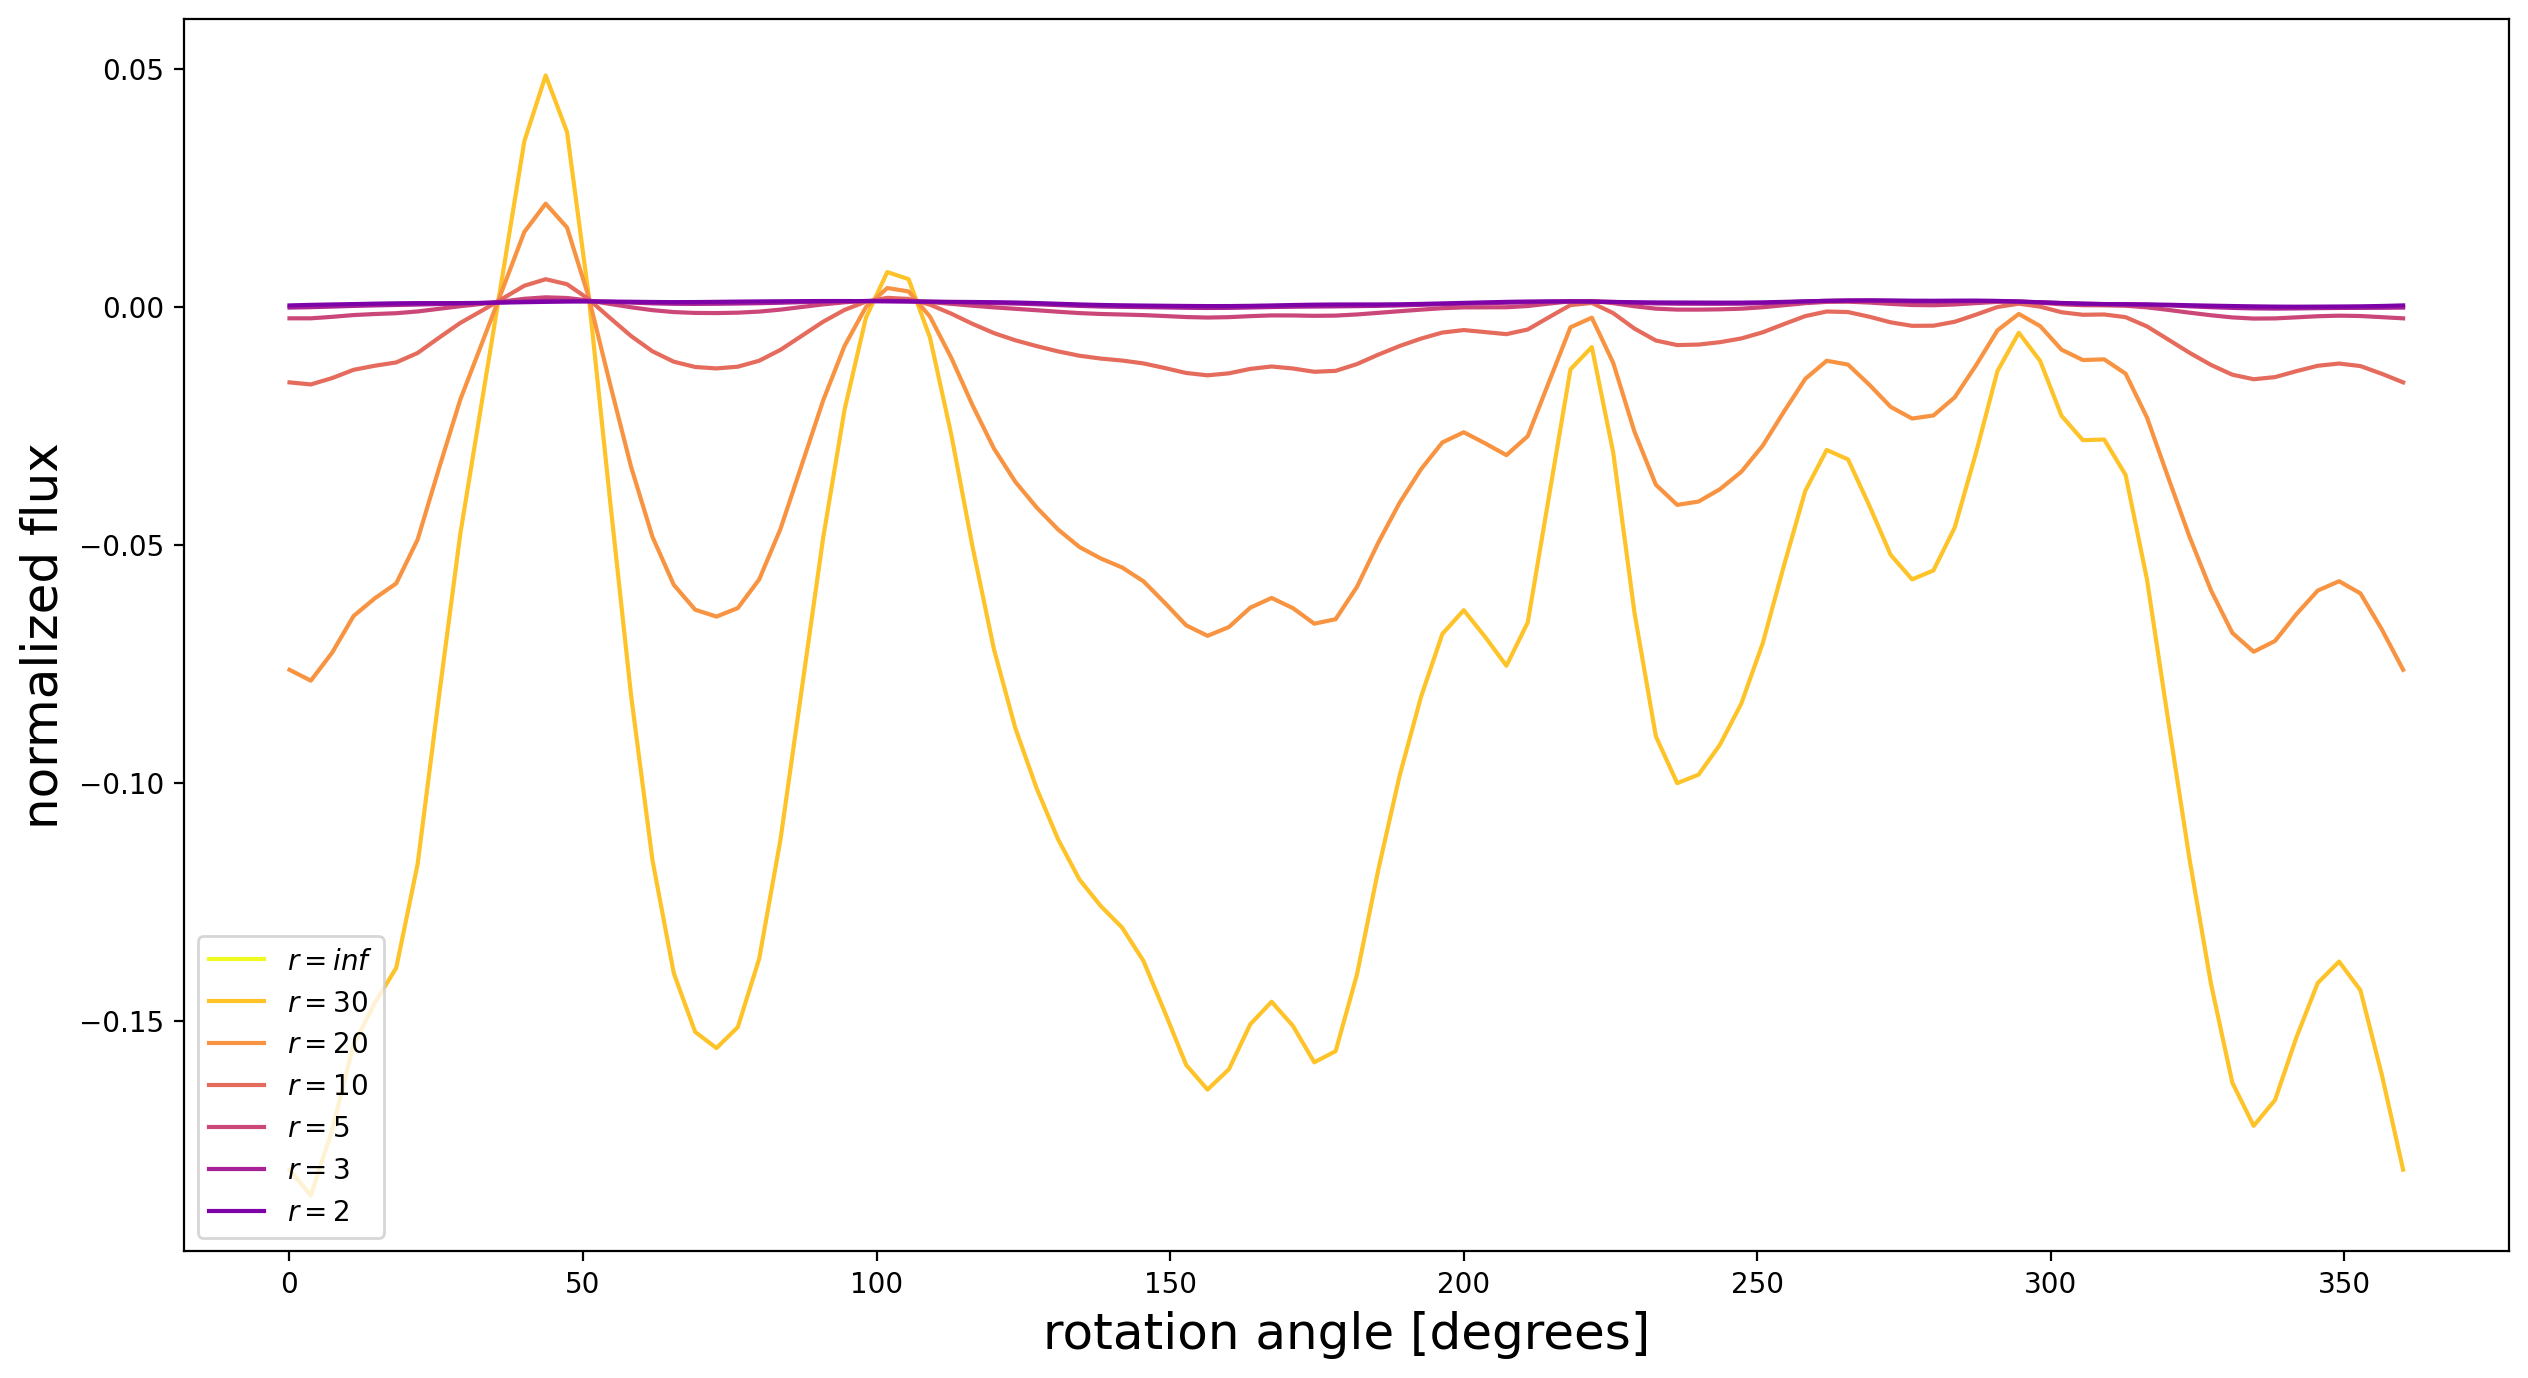

In [53]:
fig, ax = plt.subplots(1, figsize=(15, 8))
cmap = plt.get_cmap("plasma_r")
for n, x in enumerate([np.inf, 30, 20, 10, 5, 3, 2]):
    plt.plot(theta, flux(r=x,lmax=30, rs=2,vrot=0.3, theta=theta, y=map.y, inc=90), label=f"$r={x}$", color=cmap(n/8))
plt.xlabel("rotation angle [degrees]", fontsize=18)
plt.ylabel("normalized flux", fontsize=18)
plt.legend()

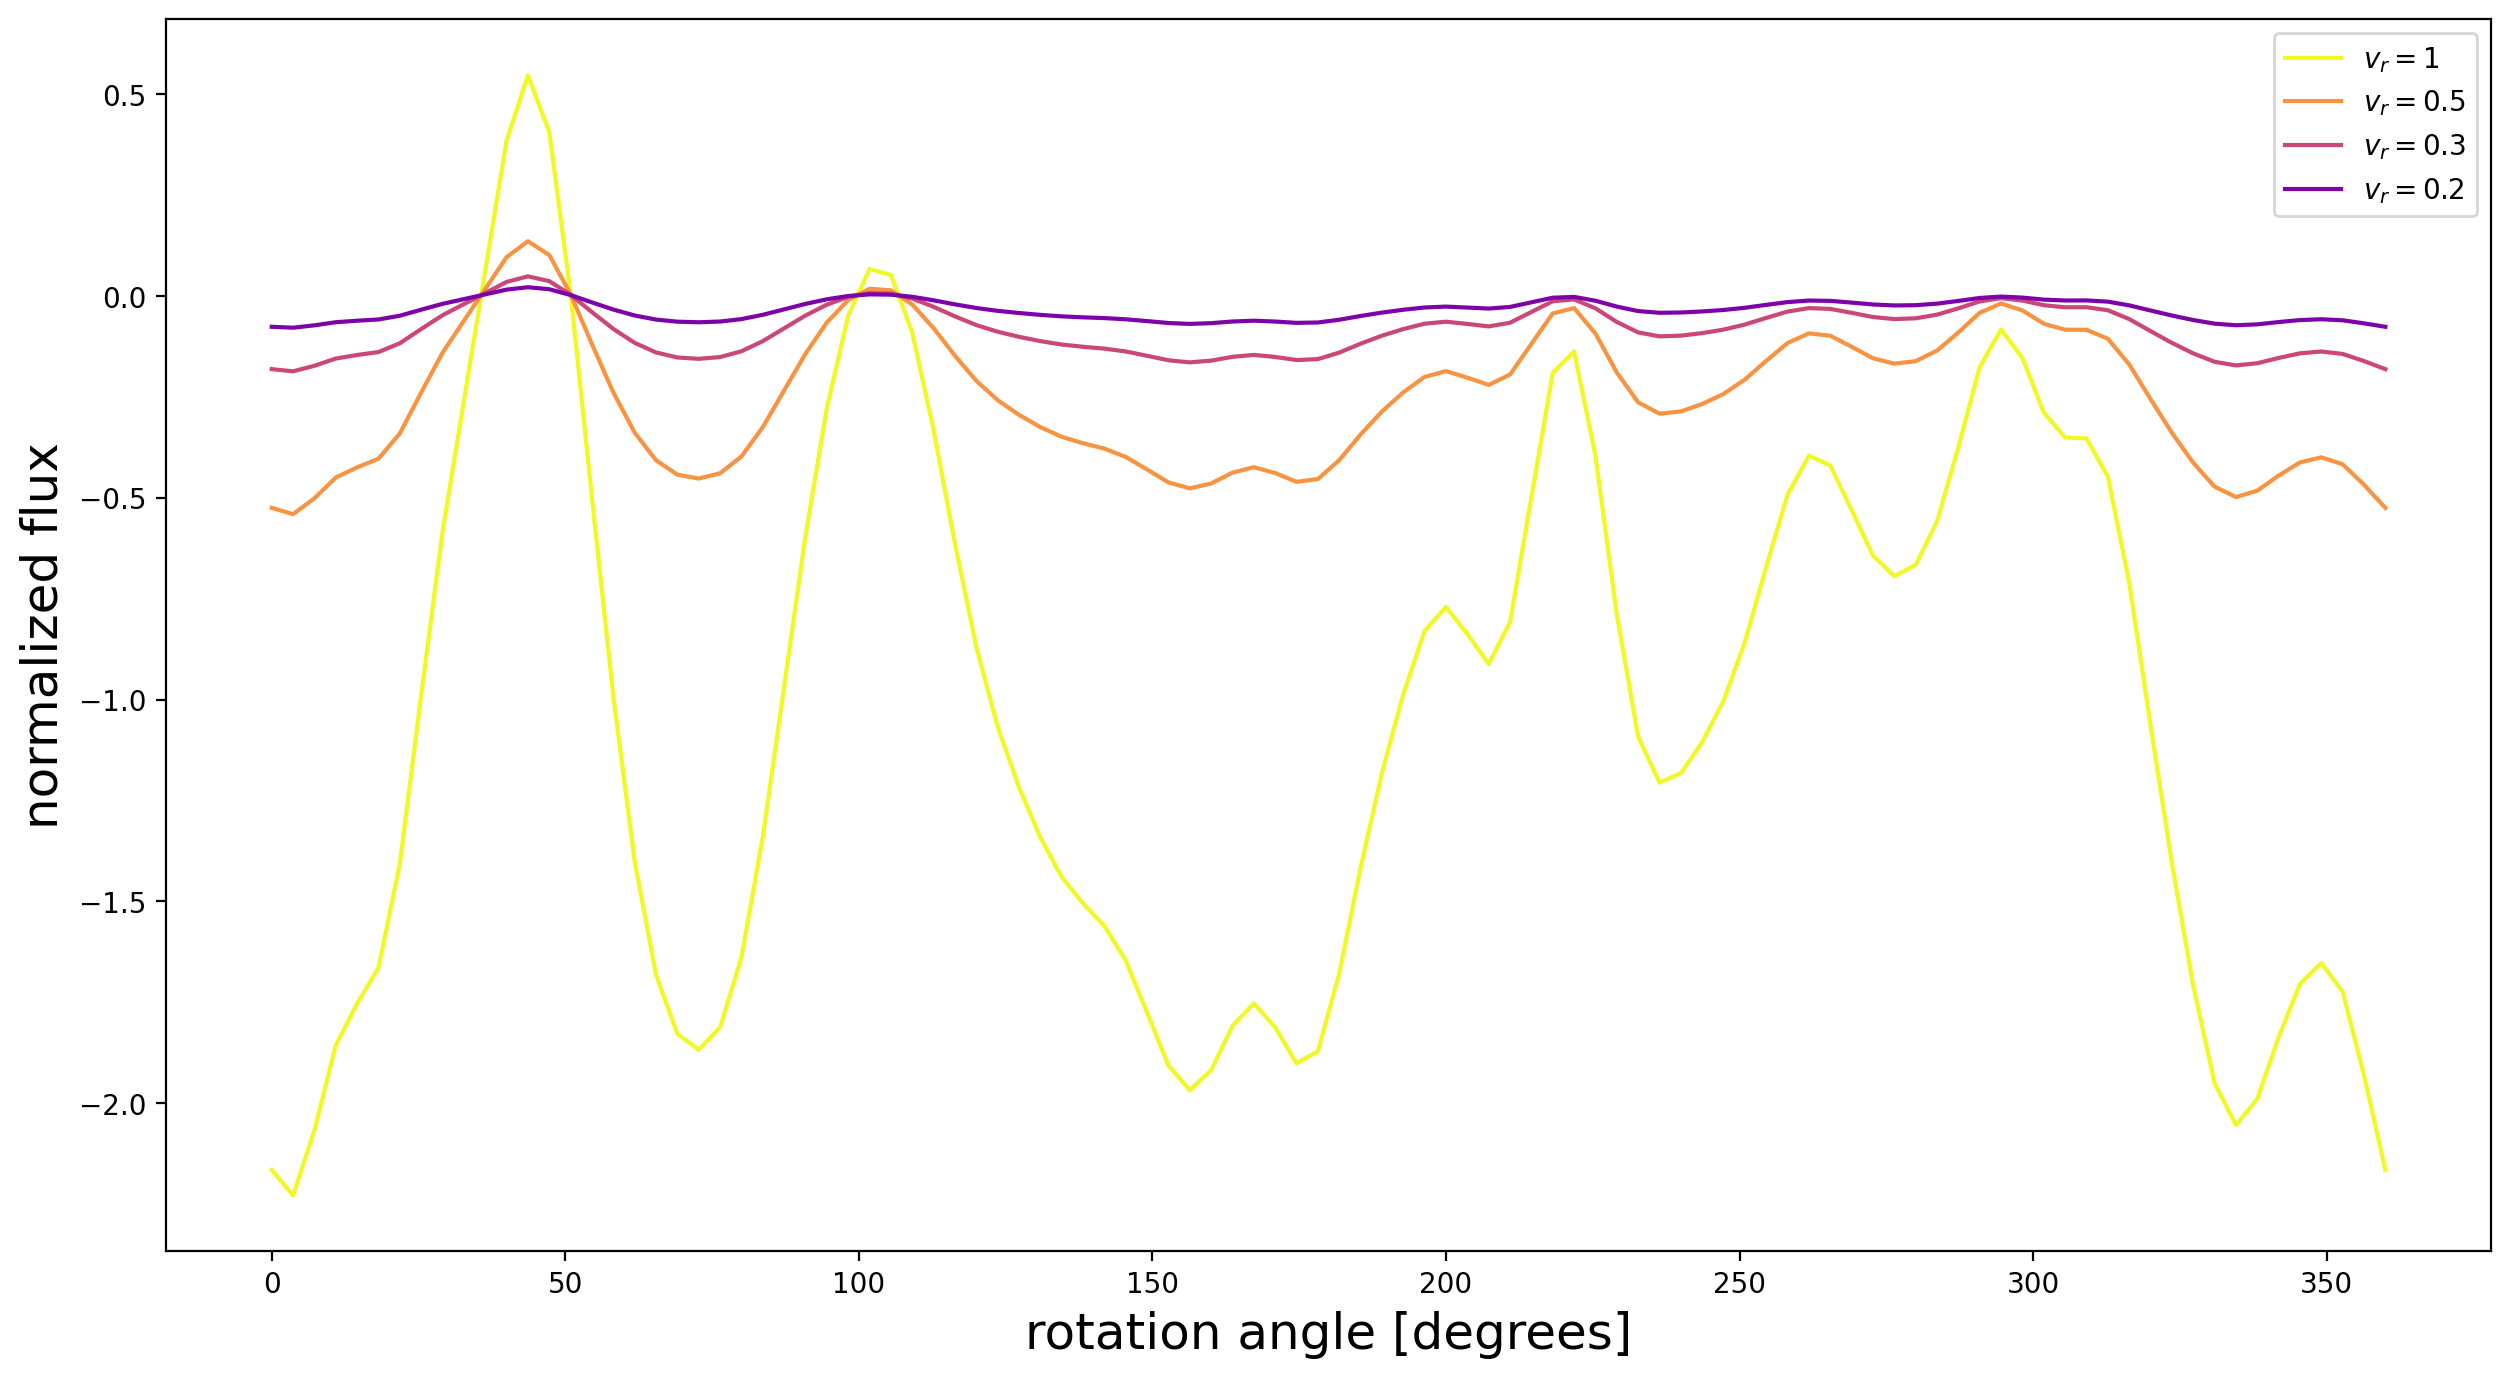

In [54]:
fig, ax = plt.subplots(1, figsize=(15, 8))
cmap = plt.get_cmap("plasma_r")
for n, vrot in enumerate([1, 0.5, 0.3, 0.2]):
    plt.plot(theta, flux(r=30,lmax=30, rs=2,vrot=vrot, theta=theta, y=map.y, inc=90), label=f"$v_r={vrot}$", color=cmap(n/4))
plt.xlabel("rotation angle [degrees]", fontsize=18)
plt.ylabel("normalized flux", fontsize=18)
plt.legend()

In [98]:
def intensity_at_point(r, lon, lat, lmax, rs, vrot):
    theta = np.pi / 2 - np.deg2rad(lat)
    phi = lon
    
    total_intensity = 0
    for l in range(lmax + 1):
        total_intensity += spherical_harmonic_intensity(r, l, theta, rs, vrot)
    
    return total_intensity

intensity = intensity_at_point(30, 30, 45, 30, 2, 0.3)
print(intensity)

38.52396935562282


In [91]:
nx = 300

x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()
lat, lon = transform(x, y, rs=rs)
I = np.zeros((len(theta), nx, nx))
for n in range(len(theta)):
    I[n] = intensity_at_point(2, lon, lat, 30, 2, 0.3).reshape(nx, nx)

In [100]:
map.show(theta=theta, image=I)